In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fmin_bfgs
%matplotlib inline

# Load and visualize the data

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
print(digits.target_names.size)

(1797, 64)
10


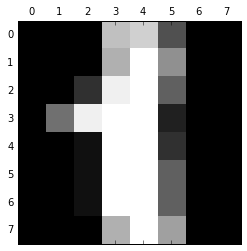

In [3]:
import pylab as pl 
pl.gray() 
pl.matshow(digits.images[1]) 
pl.show() 

# Define functions

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [6]:
def ht(X, theta):
    return sigmoid(X.dot(theta))

In [7]:
def addBiasUnit(X):
    return np.hstack((np.ones((X.shape[0], 1)), X))

In [8]:
def normalizeFeature(X): 
    mu = np.mean(X,axis=0)
    sigma = np.std(X,axis=0)
    
    X_norm = np.divide(X - mu, sigma)
    
    return (X_norm, mu, sigma)

In [9]:
def filterOneLabel(label, y):
    yi = np.zeros(y.shape)
    
    for i in range(yi.shape[0]):
        if(y[i] == label):
            yi[i] = 1
    
    return yi

In [10]:
def costFunction(nn_params, X, y, input_layer_size, hidden_layer_size, num_labels, lamda):
    m = X.shape[0]
    
    limit_between_thetas = hidden_layer_size * (input_layer_size + 1)
    t1 = np.copy(nn_params[:limit_between_thetas])
    t2 = np.copy(nn_params[limit_between_thetas:])
    
    theta1 = t1.reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = t2.reshape((num_labels, hidden_layer_size + 1))
    
    #do the forward propagation first
    #add the bias unit
    a1 = addBiasUnit(X)
    
    #calculate the output of the second layer
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    a2 = addBiasUnit(a2)
    
    #calculate the output of the last layer
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)
    h = a3
    
    #calculate the cost
    J = 0
    
    for i in range(num_labels):
        yi = filterOneLabel(i, y)
        hi = h[:, i]

        J = J + (1 / m) * np.sum(-yi * np.log(hi) - (1 - yi) * np.log(1 - hi))
        
    reg_param = (lamda / (2 * m)) * (np.sum(np.sum(theta1[:, 1:] ** 2)) + np.sum(np.sum(theta2[:, 1:] ** 2)))
    
    # add the regularization
    J = J + reg_param
    
    #calculate the gradients through backpropagation
    
    #calculate the error of the output layer
    d3 = np.zeros((num_labels, m))
    for i in range(num_labels):
        yi = filterOneLabel(i, y)
        hi = h[:, i]
        
        d3[i,:] = hi - yi
    
    #calculate the error of the hidden layer
    d2_temp = theta2.T.dot(d3)
    d2 = d2_temp[1:,:].T * sigmoidGradient(z2)
    d2 = d2.T
    
    theta2_grad = (1 / m) * d3.dot(a2)
    theta1_grad = (1 / m) * d2.dot(a1)
    
    #apply regularization to the gradients
    
    #regularization for the first layer
    reg1 = (lamda / m) * theta1
    
    #don't apply regularization for the bias unit
    reg1[:, 0] = 0
    theta1_grad = theta1_grad + reg1
    
    #regularization for the second layer
    reg2 = (lamda / m) * theta2
    
    #don't apply regularization for the bias unit
    reg2[:, 0] = 0
    theta2_grad = theta2_grad + reg2
    
    grad = np.concatenate((theta1_grad.flatten(),theta2_grad.flatten()), axis=0)
    
    return J

In [18]:
def initializeWeights(l_in, l_out):
    w = np.zeros((l_out, 1 + l_in))
    epsilon_init = np.sqrt(6) / np.sqrt(l_in + l_out)
    w = np.random.rand(l_out, l_in + 1) * 2 * epsilon_init - epsilon_init
    return w

In [26]:
def predict(theta1, theta2, X):
    m = X.shape[0]
    num_labels = theta2.shape[0]
    p = np.zeros((X.shape[0], 1))
    
    X_bias = addBiasUnit(X)
    h1 = ht(X_bias, theta1)
    h1_bias = addBiasUnit(h1)
    h2 = ht(h1_bias, theta2)
    
    y_pred = h2
    y_max = np.amax(y_pred, axis=1)
    y_indices = np.zeros((m, 1))
    
    for i in range(m):
        idx = np.where(y_pred[i, :] == y_max[i])
        y_indices[i] = idx[0][0] 
        
    return y_indices 

## Calculate the model

In [12]:
input_layer_size = digits.data.shape[1]
hidden_layer_size = 25
num_labels = digits.target_names.size

initial_theta1 = initializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = initializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate((initial_theta1.flatten(), initial_theta2.flatten()), axis=0)

print(initial_nn_params.size)

1885


In [13]:
#split the dataset into training set and validation set
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(digits.data[:100,:], digits.target[:100], test_size=0.25, random_state=7)

X = X_train
y = y_train

lamda = 0.1

In [14]:
nn_params = fmin_bfgs(costFunction, initial_nn_params, args=(X, y, input_layer_size, hidden_layer_size, num_labels, lamda), \
                      maxiter=50, disp=False)

print(nn_params)

[-0.1184998  -0.13231383  0.03140003 ...,  0.07241477  0.07288439
 -0.1984073 ]


In [24]:
print(nn_params.shape)
limit_between_thetas = hidden_layer_size * (input_layer_size + 1)
t1 = nn_params[:limit_between_thetas]
t2 = nn_params[limit_between_thetas:]

theta1 = t1.reshape((hidden_layer_size, input_layer_size + 1))
theta2 = t2.reshape((num_labels, hidden_layer_size + 1))

theta1 = theta1.T
theta2 = theta2.T

(1885,)
theta1= (65, 25)
theta2= (26, 10)


## Test the model by making predictions on the test set and measure accuracy

In [35]:
y_train_pred = predict(theta1, theta2, X_train)

from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred, average="weighted")
print("training set F1 score: ", f1)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, y_train_pred)
print("training set accuracy score: ", accuracy)

training set F1 score:  1.0
training set accuracy score:  1.0


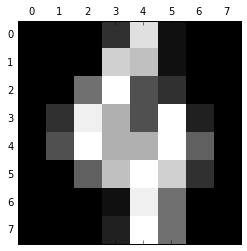

In [37]:
#test a single predicted value; it should be a 4
d = X_train[0].reshape((8,8))
pl.gray()
pl.matshow(d) 
pl.show() 

In [36]:
y_test_pred = predict(theta1, theta2, X_test)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_pred, average="weighted")
print("test set F1 score: ", f1)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_pred)
print("test set accuracy score: ", accuracy)

test set F1 score:  0.922666666667
test set accuracy score:  0.92
